In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import torch, torchvision, torch.nn.functional as F
from Model import DeepInfoMaxLoss

# Lossの収束状況確認

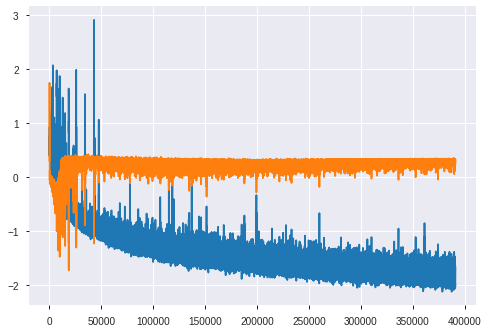

In [3]:
with open("nohup.out", "r") as f:
    losses = [[float(line[19:24]), float(line[34:39])] for line in f.readlines() if line.find('Loss') > 0]
losses = np.log(np.array(losses))
x = range(1, len(losses)+1)
plt.plot(x, losses[:, 0])
plt.plot(x, losses[:, 1])
plt.show()

# テストデータ読み取り

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
batch_size = 4
num_workers = 1

In [6]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='~/.torch/', train=True,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)
testset = torchvision.datasets.CIFAR10(root='~/.torch/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


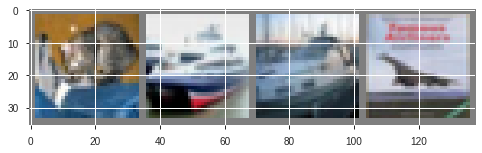

  cat  ship  ship plane


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# モデル読み取り

In [8]:
model_path = "./Models/cifar10_v3/dim_epoch_0900.pt"
dim = DeepInfoMaxLoss(alpha=0.5, beta=1.0, gamma=0.1).to(device)
dim.load_state_dict( torch.load(model_path) )
dim.eval()

DeepInfoMaxLoss(
  (encoder): Encoder(
    (c0): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1))
    (c1): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (c2): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (c3): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
    (l1): Linear(in_features=204800, out_features=64, bias=True)
    (b1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (b2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (b3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (global_D): GlobalDiscriminator(
    (c0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (c1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (l0): Linear(in_features=15552, out_features=512, bias=True)
    (l1): Linear(in_features=512, out_features=512, bias=True)
    (l2): Linear(in_features=512, out_features=1, bias=True)
  )
  (local_D): LocalDiscrimi

In [9]:
def get_y(dataloader):
    Y_list = []
    T_list = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            Y, M = dim.encoder(images.to(device))
            Y_list.append(Y.detach().cpu())
            T_list.append(labels)
    Y = torch.cat(Y_list, dim=0)
    T = torch.cat(T_list, dim=0)
    return pd.DataFrame(Y.numpy()), pd.DataFrame(T.numpy())

In [10]:
df_Y_train, df_T_train = get_y(trainloader)
df_Y_test, df_T_test = get_y(testloader)

In [11]:
columns = {c:"{:02}".format(c) for c in df_Y_train.columns}

In [12]:
df_Y_train = df_Y_train.rename(columns=columns)
df_Y_test = df_Y_test.rename(columns=columns)

# ターゲットの分布を確認

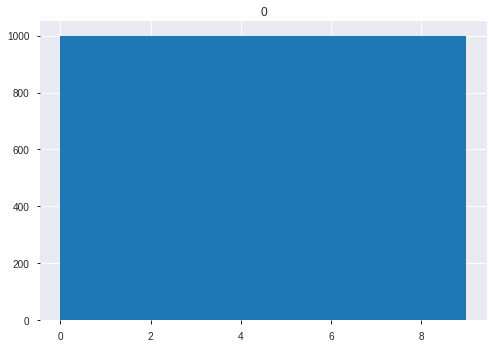

In [13]:
df_T_test.hist()
plt.show()

# 潜在表現の分布を確認

In [ ]:
df_Y_test.describe(include='all')

In [ ]:
df_Y_test.profile_report(style={'full_width':True})

# ２軸を選んで可視化

In [14]:
def scatter_plot(i, j):
    plt.scatter(df_Y_test[i], df_Y_test[j], c=df_T_test.values.flatten(), cmap='jet')

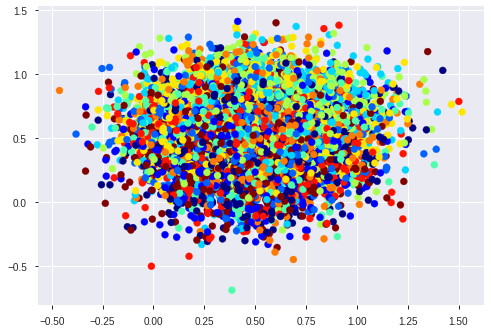

In [15]:
scatter_plot('00', '01')

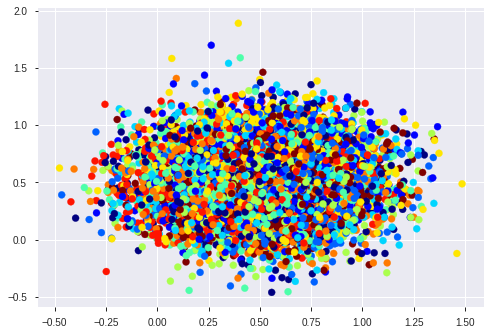

In [16]:
scatter_plot('10', '20')

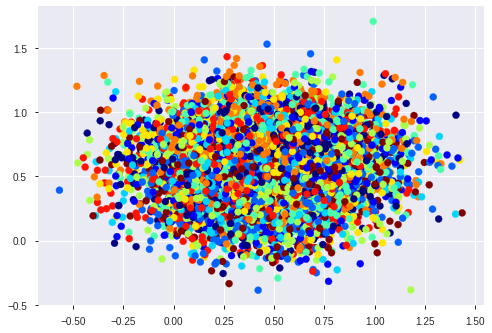

In [17]:
scatter_plot('30', '40')

# 潜在表現をtSNEで可視化

In [18]:
from sklearn.manifold import TSNE

In [19]:
%%time
Y_tsne = TSNE(n_components=2, random_state=0).fit_transform(df_Y_test)

CPU times: user 4min 41s, sys: 10 s, total: 4min 51s
Wall time: 1min 46s


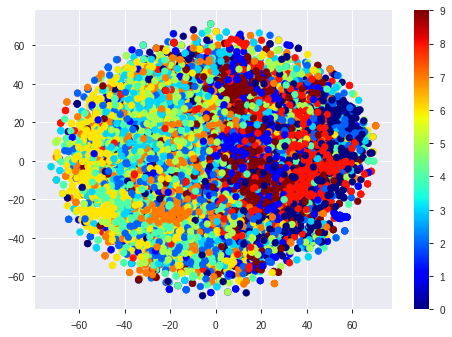

In [20]:
plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], c=df_T_test.values.flatten(), cmap='jet')
plt.colorbar()
plt.show()

# 潜在表現の線形分離性能を線形SVMで確認

In [21]:
from sklearn.metrics import f1_score, confusion_matrix

In [22]:
index = pd.MultiIndex.from_arrays([['Actual' for _ in classes], classes])
columns = pd.MultiIndex.from_arrays([['Predict' for _ in classes], classes])
def score(model):
    model.fit(df_Y_train, df_T_train)
    acc = model.score(df_Y_test, df_T_test)
    preds = model.predict(df_Y_test)
    f1micro = f1_score(df_T_test, preds, average='micro')
    print(f'Accuracy={acc}, F1(micro)={f1micro}')
    cm = confusion_matrix(df_T_test, preds)
    df_cm = pd.DataFrame(cm, index=index, columns=columns)
    display(df_cm)

In [23]:
from sklearn.svm import LinearSVC

In [24]:
%%time
score(LinearSVC())

/data/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy=0.5113, F1(micro)=0.5113


Predict                                               
               plane  car bird  cat deer  dog frog horse ship truck
Actual plane     558   59   37   22   19   16   17    25  183    64
       car       101  580   11   10    4   18   21    34   66   155
       bird      109   39  263   73  139   91  152    66   44    24
       cat        40   35   58  288   65  249  130    59   29    47
       deer       45   15   85   39  414   55  177   111   42    17
       dog        25   27   59  124   81  491   37    93   39    24
       frog       14   14   54   45   72   40  706    28   12    15
       horse      34   30   40   30   71   93   36   582   25    59
       ship      124   87   14   14    7   13   16    20  657    48
       truck      67  183   18   11    8   14   22    36   67   574

CPU times: user 1min 12s, sys: 17.8 ms, total: 1min 12s
Wall time: 1min 11s


# ロジスティック回帰

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
%%time
score(LogisticRegression())

/data/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/data/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/data/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy=0.5166, F1(micro)=0.5166


Predict                                               
               plane  car bird  cat deer  dog frog horse ship truck
Actual plane     561   58   53   25   18   16   13    25  169    62
       car       102  572   21   11    5   18   15    35   64   157
       bird       88   30  331   85  128   85  132    64   32    25
       cat        35   26   82  353   60  210  108    56   26    44
       deer       40   10  116   50  425   51  152   102   39    15
       dog        21   18   80  168   79  463   32    86   33    20
       frog       10   12   73   56   82   37  677    27   12    14
       horse      36   21   52   44   78   90   25   577   20    57
       ship      136   85   18   19    8   14   12    22  633    53
       truck      66  174   20   19    8   16   20    44   59   574

CPU times: user 9.68 s, sys: 78.7 ms, total: 9.76 s
Wall time: 8.89 s


# ランダムフォレスト

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
%%time
score(RandomForestClassifier())

/data/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/data/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Accuracy=0.3051, F1(micro)=0.3051


Predict                                               
               plane  car bird  cat deer  dog frog horse ship truck
Actual plane     483   96   68   44   37   38   24    35  126    49
       car       145  408   40   46   36   42   32    44   89   118
       bird      159   76  234  105  129   78   97    58   26    38
       cat        93   95  153  220   88  157   97    42   32    23
       deer       97   57  173  101  264   77  106    78   30    17
       dog       107   76  122  180   93  233   50    68   38    33
       frog       32   57  138  113  119   77  394    32   21    17
       horse     105   95  112  104  129   74   52   252   35    42
       ship      215  141   62   47   29   43   28    31  351    53
       truck     122  259   71   61   37   55   43    53   87   212

CPU times: user 4.97 s, sys: 40 ms, total: 5.01 s
Wall time: 4.29 s


# 勾配ブースティング決定木

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

In [28]:
%%time
score(GradientBoostingClassifier())

/data/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy=0.4759, F1(micro)=0.47589999999999993


Predict                                               
               plane  car bird  cat deer  dog frog horse ship truck
Actual plane     536   57   56   26   19   13   10    48  175    60
       car       103  537   21   16    9   14   22    37   78   163
       bird       86   34  336   67  137   87  116    60   41    36
       cat        30   49   89  314   75  205  123    40   29    46
       deer       45   21  125   44  419   47  127   116   34    22
       dog        27   33   72  178   79  416   59    70   39    27
       frog       20   29   67   66   96   37  621    31   14    19
       horse      36   37   52   59   85  107   50   505   20    49
       ship      170   91   19   22   19   19   14    21  579    46
       truck      74  189   31   24    7   21   21    54   83   496

CPU times: user 22min 8s, sys: 55.8 s, total: 23min 3s
Wall time: 6min 24s
